# Modelo
Lo que nos interesa lograr con nuestro modelo es tener una forma de predecir de manera eficaz lo que se esta viendo en una imagen/set de imagenes astronomicos, esto es muy importante ya que los set de datos astronomicos contienen desde miles a millones de imagenes cada uno, por lo cual es necesario tener una manera eficaz de poder estudiar lo que se está observando.

Es importante destacar que nos basamos en "Alerce", mas especificamente en el proyecto "Stamp classifier".



# La CNN

La parte mas importante de nuestro codigo es donde se define el modelo convolucional en si.
Partimos con la entrada de las imagenes, a modo muy simple esto se hace a través de la variable "image_input" la cual espera imagenes de 21x21 pixeles y 3 canales.

Tras ello viene el data augmentation, en donde se normalizan los valores de los pixeles de las imagenes, junto a esto se aplica un "padding" el cual netamente añade ceros alrededor de la imagen, para así pasarlas al formato (27,27,3).Después de hacer esto se aplican distintas rotaciones, esto se hace debido a que las imagenes astronomicas no tienen una orientación fija, debido a ello se decidió aplicar rotaciones aleatorias para asi ayudar a que el modelo se desempeñe de mejor manera en un ambiente real.

Dentro de las capas convolucionales hay varias caracteristicas destacables.Iniciamos con una capa convolucional de 32 filtros de 3x3 y una función de activación ReLU, sumado a ello se utiliza el relleno same para mantener el tamaño espacial de las imagenes, seguimos con "batch normalization" que normaliza las activaciones anteriores,también utilizamos maxpooling2D la cual simplemente reduce el tamaño de la salida.

Finalmente se concatenan las salidas de las capas convolucionales para luego aplanarlas mediante un flatten y regularizarlas mediante un dropout

# Caracteristicas clave
- Los datos entregados al modelo están en formato pickle, se eligió este formato debido a su simpleza y facilidad de manejo.
- Se dividió el set de datos en 2, con una proporción 80 entrenamiento/20 prueba.
- Al definir el modleo se deció hacer un data augmentation dentro de este(el cual consitió en normalizar y realizar ciertas transformaciones(como rotaciones) a imagenes al azar).
- El modelo en si es posible dividirlo en 2 grandes grupos uno convolucional y uno de metadatos, los cuales finalmente seran unidos para asi dar forma a nuestro modelo.
- Finalmente se compila y entrena el modelo
- Tras ello es posible observar distintas caracteristicas de este como gráficas de perdida y entrenamiento, junto con un output de predicción vs realiad con la diferencia entre ambas imagenes.
- Finalizado todo lo anterior se guarda el modelo

In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tensorflow.keras import layers, Model, Input
from sklearn.preprocessing import LabelEncoder, StandardScaler, LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

In [3]:
plt.style.use('dark_background') # Elección estetica

In [4]:
@tf.keras.utils.register_keras_serializable()
class RotationLayer(layers.Layer):
    def __init__(self, k, **kwargs):
        super().__init__(**kwargs)
        self.k = k

    def call(self, inputs):
        return tf.image.rot90(inputs, k=self.k)

    def get_config(self):
        config = super().get_config()
        config.update({"k": self.k})
        return config

In [5]:
# Carga de datos
AGN = pd.read_pickle("./Dataset_grande_pickle/ztf_avro_Grande_AGN.pkl")
QSO = pd.read_pickle("./Dataset_grande_pickle/ztf_avro_Grande_QSO.pkl")
VS = pd.read_pickle("./Dataset_grande_pickle/ztf_avro_Grande_Variable_Star.pkl")
YSO = pd.read_pickle("./Dataset_grande_pickle/ztf_avro_Grande_YSO.pkl")
Other = pd.read_pickle("./Dataset_grande_pickle/ztf_avro_Grande_Other.pkl")

In [6]:
# Lista de todos los dataframes
dataframes = [AGN, QSO, VS, YSO, Other]

# Listas para almacenar los splits
X_trains = []
X_vals = []
X_tests = []
y_trains = []
y_vals = []
y_tests = []

# Columnas de características (todas menos 'label')
feature_columns = ['object_id', 'data', 'ra', 'dec', 'magpsf', 'sigmapsf', 'isdiffpos',
                  'diffmaglim', 'fwhm', 'sgscore1', 'sgscore2', 'sgscore3', 'distpsnr1',
                  'distpsnr2', 'distpsnr3', 'classtar', 'ndethist', 'ncovhist', 'chinr',
                  'sharpnr', 'gal_lat', 'gal_lng', 'ecl_lat', 'ecl_lng', 'approx_nondet']

# Hacer split para cada dataset
for df in dataframes:
    X = df[feature_columns]
    y = df['label']

    # Primero split para test
    X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    # Ahora split para validación (20% de lo restante, es decir 16% del total)
    X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.2, random_state=42)

    X_trains.append(X_train)
    X_vals.append(X_val)
    X_tests.append(X_test)
    y_trains.append(y_train)
    y_vals.append(y_val)
    y_tests.append(y_test)

# Concatenar todos los datos de entrenamiento
X_train_final = pd.concat(X_trains, axis=0)
y_train_final = pd.concat(y_trains, axis=0)

# Concatenar todos los datos de validación
X_val_final = pd.concat(X_vals, axis=0)
y_val_final = pd.concat(y_vals, axis=0)

# Concatenar todos los datos de prueba
X_test_final = pd.concat(X_tests, axis=0)
y_test_final = pd.concat(y_tests, axis=0)

# Mezclar aleatoriamente los datos concatenados
train_index = np.random.permutation(len(X_train_final))
val_index = np.random.permutation(len(X_val_final))
test_index = np.random.permutation(len(X_test_final))

X_train_final = X_train_final.iloc[train_index].reset_index(drop=True)
y_train_final = y_train_final.iloc[train_index].reset_index(drop=True)
X_val_final = X_val_final.iloc[val_index].reset_index(drop=True)
y_val_final = y_val_final.iloc[val_index].reset_index(drop=True)
X_test_final = X_test_final.iloc[test_index].reset_index(drop=True)
y_test_final = y_test_final.iloc[test_index].reset_index(drop=True)

In [7]:
# Convertir etiquetas de texto a números
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train_final)
y_val_encoded = label_encoder.transform(y_val_final)
y_test_encoded = label_encoder.transform(y_test_final)

# Transformar a oneshot encoding
y_train = to_categorical(y_train_encoded)
y_val = to_categorical(y_val_encoded)
y_test = to_categorical(y_test_encoded)


label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Mapeo de etiquetas:", label_mapping)

Mapeo de etiquetas: {'AGN': 0, 'Other': 1, 'QSO': 2, 'VS': 3, 'YSO': 4}


- Es más estándar trabajar con el formato (N, height, width, channels)
- Las capas Conv2D de Keras están optimizadas para este formato
- Es más fácil de visualizar y debuggear

In [8]:
metadata_columns = ['ra', 'dec', 'magpsf', 'sigmapsf', 'isdiffpos', 'diffmaglim', 'fwhm',
                  'sgscore1', 'sgscore2', 'sgscore3', 'distpsnr1', 'distpsnr2', 'distpsnr3',
                  'classtar', 'ndethist', 'ncovhist', 'chinr', 'sharpnr', 'gal_lat', 'gal_lng',
                  'ecl_lat', 'ecl_lng', 'approx_nondet']

X_train_data = np.stack(X_train_final['data'])
X_train_metadata = X_train_final[metadata_columns].values.astype('float32')

X_val_data = np.stack(X_val_final['data'])
X_val_metadata = X_val_final[metadata_columns].values.astype('float32')

X_test_data = np.stack(X_test_final['data'])
X_test_metadata = X_test_final[metadata_columns].values.astype('float32')

# Normalizar metadatos
scaler = StandardScaler()
X_train_metadata = scaler.fit_transform(X_train_metadata)
X_val_metadata = scaler.transform(X_val_metadata)
X_test_metadata = scaler.transform(X_test_metadata)

# Transformamos de (N, 3, 21, 21) a (N, 21, 21, 3)
X_train_data = np.transpose(X_train_data, (0, 2, 3, 1))
X_val_data = np.transpose(X_val_data, (0, 2, 3, 1))
X_test_data = np.transpose(X_test_data, (0, 2, 3, 1))

In [9]:
BATCH_SIZE = 256
train_dataset = tf.data.Dataset.from_tensor_slices(({
    'image_input': X_train_data,
    'metadata_input': X_train_metadata
}, y_train))

val_dataset = tf.data.Dataset.from_tensor_slices(({
    'image_input': X_val_data,
    'metadata_input': X_val_metadata
}, y_val))


test_dataset = tf.data.Dataset.from_tensor_slices(({
    'image_input': X_test_data,
    'metadata_input': X_test_metadata
}, y_test))

train_dataset = train_dataset.shuffle(1000).batch(BATCH_SIZE)
val_dataset = val_dataset.batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

I0000 00:00:1750992558.624885   11595 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5592 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060 Ti, pci bus id: 0000:10:00.0, compute capability: 8.6


In [10]:
# Set de imagenes
image_input = Input(shape=(21, 21, 3), name='image_input')

# Data Augmentation
normalized = layers.Rescaling(1./255)(image_input)
padded = layers.ZeroPadding2D(padding=3)(normalized)

# Crear 4 rotaciones
rotation_0 = padded
rotation_90 = RotationLayer(k=1)(padded)
rotation_180 = RotationLayer(k=2)(padded)
rotation_270 = RotationLayer(k=3)(padded)

rotations = [rotation_0, rotation_90, rotation_180, rotation_270]

# Aplicar las capas convolucionales a cada rotación
conv_outputs = []
for rotation in rotations:
    x = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(rotation)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.25)(x)

    x = layers.Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.25)(x)

    x = layers.Conv2D(128, (3, 3), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(128, (3, 3), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.25)(x)

    conv_outputs.append(x)

# Concatenacion de los outputs y las capas convolucionales
concatenated_conv = layers.Concatenate()(conv_outputs)

x = layers.Flatten()(concatenated_conv)
x = layers.Dense(128, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)
image_output = x

# Metadatos
metadata_input = Input(shape=(23,), name='metadata_input')
y = layers.Dense(128, activation='relu')(metadata_input)
y = layers.BatchNormalization()(y)
y = layers.Dropout(0.25)(y)
y = layers.Dense(64, activation='relu')(y)
y = layers.BatchNormalization()(y)
y = layers.Dropout(0.25)(y)
metadata_output = y

# Fusión
combined = layers.Concatenate()([image_output, metadata_output])
z = layers.Dense(64, activation='relu')(combined)
z = layers.BatchNormalization()(z)
z = layers.Dropout(0.5)(z)
output = layers.Dense(len(label_encoder.classes_), activation='softmax')(z)

In [11]:
model = Model(inputs=[image_input, metadata_input], outputs=output)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, clipnorm=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image_input         │ (None, 21, 21, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 21, 21, 3) │          0 │ image_input[0][0] │
│ (Rescaling)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 27, 27, 3) │          0 │ rescaling[0][0]   │
│ (ZeroPadding2D)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rotation_layer      │ (None, 27, 27, 3) │          0 │ zero_padding2d[0… │
│ (RotationLayer)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rotation_layer_1    │ (None, 27, 27, 3) │          0 │ zero_padding2d[0… │
│ (RotationLayer)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rotation_layer_2    │ (None, 27, 27, 3) │          0 │ zero_padding2d[0… │
│ (RotationLayer)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 27, 27,    │        896 │ zero_padding2d[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 27, 27,    │        896 │ rotation_layer[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_12 (Conv2D)  │ (None, 27, 27,    │        896 │ rotation_layer_1… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_18 (Conv2D)  │ (None, 27, 27,    │        896 │ rotation_layer_2… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 27, 27,    │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 27, 27,    │        128 │ conv2d_6[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 27, 27,    │        128 │ conv2d_12[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 27, 27,    │        128 │ conv2d_18[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 27, 27,    │      9,248 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 27, 27,    │      9,248 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_13 (Conv2D)  │ (None, 27, 27,    │      9,248 │ batch_normalizat

 Total params: 1,770,693 (6.75 MB)

 Trainable params: 1,766,341 (6.74 MB)

 Non-trainable params: 4,352 (17.00 KB)

#### Callbacks:
EarlyStopping:
- monitor='val_loss': Observa la pérdida en validación
- patience=10: Espera 50 épocas sin mejora antes de detener
- restore_best_weights=True: Restaura los mejores pesos encontrados

ReduceLROnPlateau:
- monitor='val_loss': También observa la pérdida en validación
- factor=0.2: Reduce la tasa de aprendizaje al 20% de su valor actual
- patience=5: Espera 10 épocas sin mejora antes de reducir la tasa
- min_lr=1e-6: No reduce la tasa por debajo de este valor

In [12]:
# Configurar callbacks
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=40,
        restore_best_weights=True
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=25,
        min_lr=0.001
    )
]

#### Entrenamiento:

In [13]:
# Entrenar el modelo
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=100,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/100


I0000 00:00:1750992592.090404   11687 service.cc:152] XLA service 0x786700001650 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1750992592.090492   11687 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Ti, Compute Capability 8.6
2025-06-26 22:49:53.781433: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-06-26 22:49:55.931556: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator functional_1/rotation_layer_2_1/rot90/Assert/AssertGuard/Assert
2025-06-26 22:49:55.936606: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator functional_1/rotation_layer_1_1/rot90/Assert/AssertGuard/Assert
2025-06-26 22:49:55.940403: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator functional_1/rotation_layer_3/rot90/Assert/AssertGuard/Assert
I

89/90 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.3348 - loss: 1.9158

2025-06-26 22:50:53.646390: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator functional_1/rotation_layer_2_1/rot90/Assert/AssertGuard/Assert
2025-06-26 22:50:53.648760: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator functional_1/rotation_layer_1_1/rot90/Assert/AssertGuard/Assert
2025-06-26 22:50:53.650673: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator functional_1/rotation_layer_3/rot90/Assert/AssertGuard/Assert


90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 613ms/step - accuracy: 0.3354 - loss: 1.9133

2025-06-26 22:51:42.812175: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator functional_1/rotation_layer_2_1/rot90/Assert/AssertGuard/Assert
2025-06-26 22:51:42.815134: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator functional_1/rotation_layer_1_1/rot90/Assert/AssertGuard/Assert
2025-06-26 22:51:42.819148: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator functional_1/rotation_layer_3/rot90/Assert/AssertGuard/Assert
2025-06-26 22:51:47.417365: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator functional_1/rotation_layer_2_1/rot90/Assert/AssertGuard/Assert
2025-06-26 22:51:47.418979: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator functional_1/rotation_layer_1_1/rot90/Assert/AssertGuard/Assert
2025-06-26 22:51:47.420833: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator functional_1/rotation_layer_3/rot90/Asse

90/90 ━━━━━━━━━━━━━━━━━━━━ 148s 724ms/step - accuracy: 0.3360 - loss: 1.9109 - val_accuracy: 0.4384 - val_loss: 1.2797 - learning_rate: 0.0010
Epoch 2/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step - accuracy: 0.4905 - loss: 1.3196 - val_accuracy: 0.5327 - val_loss: 1.1422 - learning_rate: 0.0010
Epoch 3/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 6s 67ms/step - accuracy: 0.5447 - loss: 1.1362 - val_accuracy: 0.5514 - val_loss: 1.0625 - learning_rate: 0.0010
Epoch 4/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 6s 65ms/step - accuracy: 0.5610 - loss: 1.0609 - val_accuracy: 0.5528 - val_loss: 1.0265 - learning_rate: 0.0010
Epoch 5/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 6s 67ms/step - accuracy: 0.5692 - loss: 1.0331 - val_accuracy: 0.5723 - val_loss: 0.9904 - learning_rate: 0.0010
Epoch 6/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 6s 64ms/step - accuracy: 0.5802 - loss: 1.0035 - val_accuracy: 0.5812 - val_loss: 0.9897 - learning_rate: 0.0010
Epoch 7/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 6s 62ms/step - accuracy: 0.5883 - loss: 0.9744 - val_accur

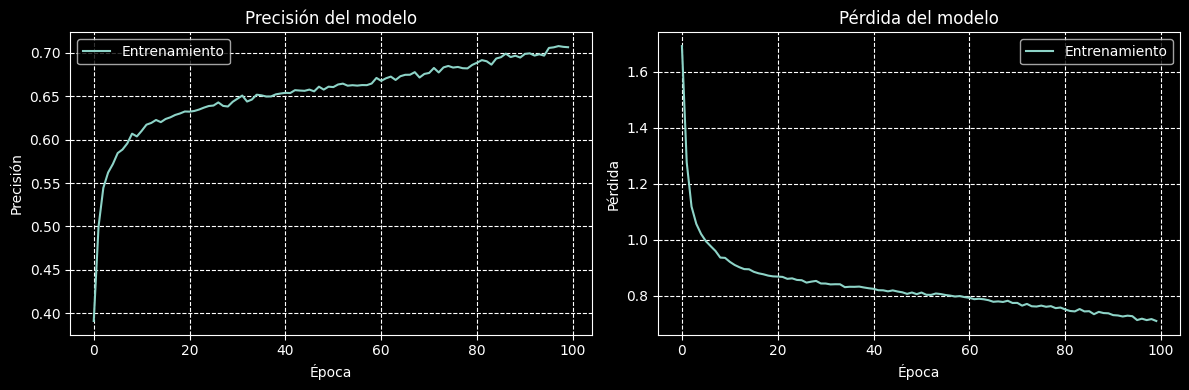

In [14]:
# Visualización del entrenamiento
plt.figure(figsize=(12, 4))

# Gráfico de precisión
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Entrenamiento')
plt.title('Precisión del modelo')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.legend()
plt.grid(True, linestyle = '--')

# Gráfico de pérdida
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Entrenamiento')
plt.title('Pérdida del modelo')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()

plt.tight_layout()
plt.grid(True, linestyle = '--')
plt.show()

2025-06-26 23:00:40.586066: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator functional_1/rotation_layer_2_1/rot90/Assert/AssertGuard/Assert
2025-06-26 23:00:40.589592: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator functional_1/rotation_layer_1_1/rot90/Assert/AssertGuard/Assert
2025-06-26 23:00:40.592634: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator functional_1/rotation_layer_3/rot90/Assert/AssertGuard/Assert


Clase predicha: VS
Clase real: VS


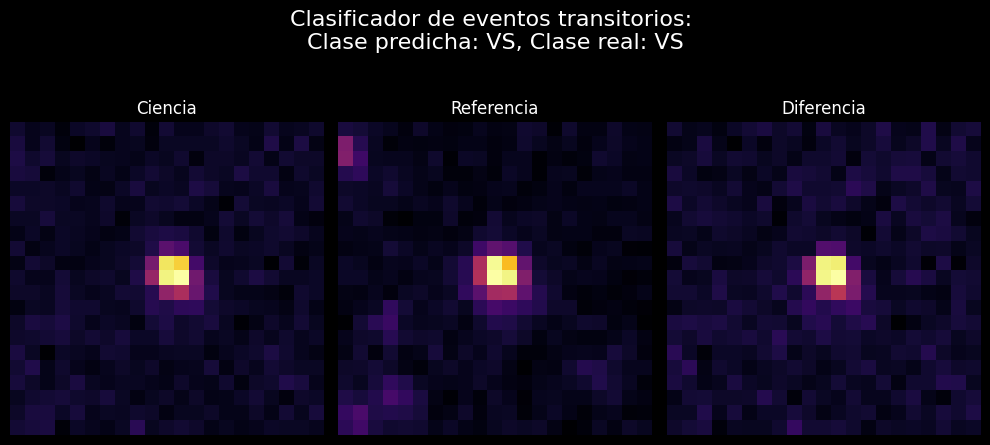

In [15]:
numero = 9 # Elegimos una imagen al azar(se coloca a mano el nuemro de la imagen)
imagen = X_test_data[numero]
imagen = np.stack([imagen])
metadata = X_test_metadata[numero]
metadata = np.stack([metadata])

prediccion = model.predict({'image_input': imagen,'metadata_input': metadata}, verbose=0)# Predicción del modelo

clase_predicha = np.argmax(prediccion, axis=1)[0] # Clase predicha por el modelo
print(f'Clase predicha: {label_encoder.inverse_transform([clase_predicha])[0]}')

y_test_encoded[numero]
print(f'Clase real: {y_test_final.iloc[numero]}')

fig, axes = plt.subplots(1, 3, figsize=(10, 5))
fig.suptitle(f'Clasificador de eventos transitorios: \nClase predicha: {label_encoder.inverse_transform([clase_predicha])[0]}, Clase real: {y_test_final.iloc[numero]}', fontsize=16)
axes[0].imshow(imagen[0,:,:,0], cmap='inferno')
axes[0].set_title('Ciencia')
axes[0].axis('off')
axes[1].imshow(imagen[0,:,:,1], cmap='inferno')
axes[1].set_title('Referencia')
axes[1].axis('off')
axes[2].imshow(imagen[0,:,:,2], cmap='inferno')
axes[2].set_title('Diferencia')
axes[2].axis('off')
plt.tight_layout()
plt.show()

2025-06-26 23:00:45.333488: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator functional_1/rotation_layer_2_1/rot90/Assert/AssertGuard/Assert
2025-06-26 23:00:45.336646: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator functional_1/rotation_layer_1_1/rot90/Assert/AssertGuard/Assert
2025-06-26 23:00:45.339068: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator functional_1/rotation_layer_3/rot90/Assert/AssertGuard/Assert


26/28 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step

2025-06-26 23:00:49.030907: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator functional_1/rotation_layer_2_1/rot90/Assert/AssertGuard/Assert
2025-06-26 23:00:49.033258: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator functional_1/rotation_layer_1_1/rot90/Assert/AssertGuard/Assert


28/28 ━━━━━━━━━━━━━━━━━━━━ 8s 166ms/step


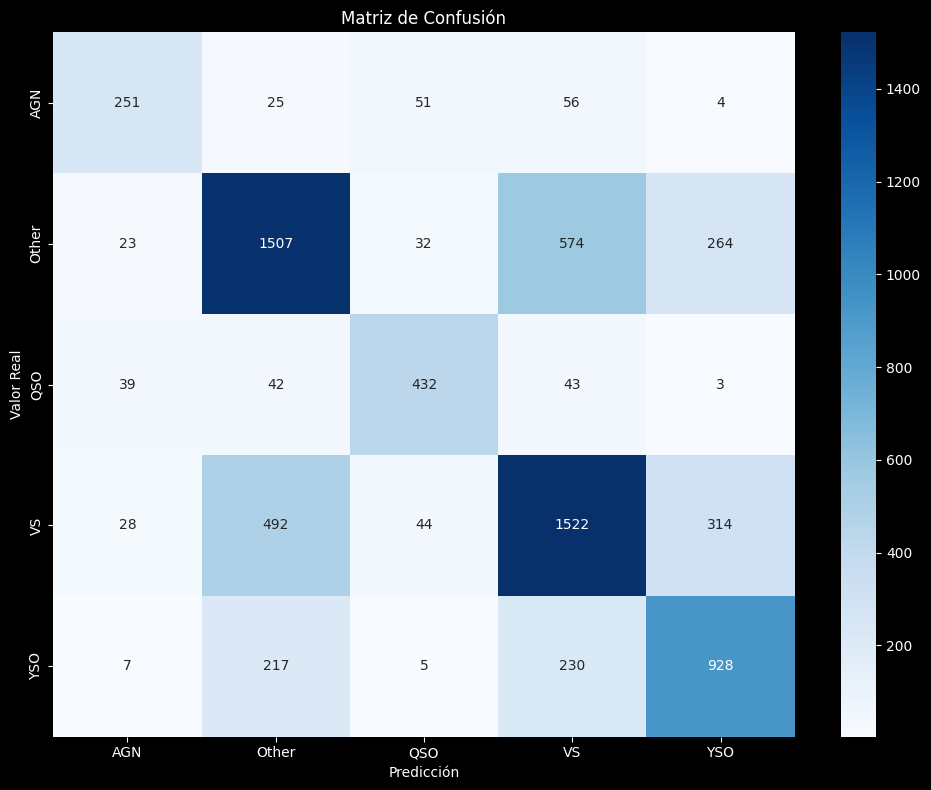


Reporte de Clasificación:
              precision    recall  f1-score   support

         AGN       0.72      0.65      0.68       387
       Other       0.66      0.63      0.64      2400
         QSO       0.77      0.77      0.77       559
          VS       0.63      0.63      0.63      2400
         YSO       0.61      0.67      0.64      1387

    accuracy                           0.65      7133
   macro avg       0.68      0.67      0.67      7133
weighted avg       0.65      0.65      0.65      7133



In [16]:
# Predicciones del modelo de prueba
predicciones = model.predict(test_dataset)
y_pred = np.argmax(predicciones, axis=1)
y_true = np.argmax(y_test, axis=1)

# Creación de la matriz de confusión
cm = confusion_matrix(y_true, y_pred)

# Nombres de las clases
class_names = label_encoder.classes_

# Visualizamos la matriz de confusión
plt.figure(figsize=(10, 8))
sns.heatmap(cm,
            annot=True,
            fmt='d',
            cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.title('Matriz de Confusión')
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.tight_layout()
plt.show()


print("\nReporte de Clasificación:")
print(classification_report(y_true, y_pred, target_names=class_names))

## Conclusiones

El modelo muestra un desempeño general moderado, con una precisión global (accuracy) del 65 % sobre un total de 7133 muestras. El análisis por clase revela que:

- La clase QSO (Quasi-Stellar Object) tiene el mejor desempeño con un F1-score de 0.77, indicando que el modelo es especialmente efectivo para identificar esta clase.

- Las clases AGN y VS tienen F1-scores de 0.68 y 0.63 respectivamente, lo que refleja un rendimiento aceptable pero con margen de mejora.

- Las clases Other y YSO presentan dificultades, con F1-scores de 0.64 en ambos casos, y en particular, YSO muestra una gran cantidad de muestras mal clasificadas como Other y VS, lo cual podría deberse a similitudes espectrales o temporales entre estas clases.

La matriz de confusión también muestra una confusión significativa entre "Other" y las clases VS e YSO, lo que sugiere que el modelo no logra distinguir correctamente ciertas características representativas de estas clases. Por ejemplo:

- De los 2400 objetos clasificados como “Other”, 574 eran realmente VS y 264 eran YSO.

- Asimismo, muchos VS reales (492) fueron predichos erróneamente como “Other”.

Algunas de las formas para mejorar el modelo sería, balancear las clases para que sean más homogéneas en magnitud o crear la clasificación de Bogus (imagines con artefactos) para evitar corromper el aprendizaje del modelo.

In [ ]:
# Guardado del modelo
model.save('Modelo_entrenado_v33.keras')
model.save('Modelo_entrenado_v33.h5')

In [ ]:
# Cargamos el modelo guardado
# WARNING: Se debe tener la clase RotationLayer con el decorador de keras cargados en el codigo para cargar el modelo.
modelo_cargado = tf.keras.models.load_model('./Modelo_entrenado_v33.h5')

# Sumario del modelo
modelo_cargado.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image_input         │ (None, 21, 21, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 21, 21, 3) │          0 │ image_input[0][0] │
│ (Rescaling)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 27, 27, 3) │          0 │ rescaling[0][0]   │
│ (ZeroPadding2D)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rotation_layer      │ (None, 27, 27, 3) │          0 │ zero_padding2d[0… │
│ (RotationLayer)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rotation_layer_1    │ (None, 27, 27, 3) │          0 │ zero_padding2d[0… │
│ (RotationLayer)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rotation_layer_2    │ (None, 27, 27, 3) │          0 │ zero_padding2d[0… │
│ (RotationLayer)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 27, 27,    │        896 │ zero_padding2d[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 27, 27,    │        896 │ rotation_layer[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_12 (Conv2D)  │ (None, 27, 27,    │        896 │ rotation_layer_1… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_18 (Conv2D)  │ (None, 27, 27,    │        896 │ rotation_layer_2… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 27, 27,    │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 27, 27,    │        128 │ conv2d_6[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 27, 27,    │        128 │ conv2d_12[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 27, 27,    │        128 │ conv2d_18[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 27, 27,    │      9,248 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 27, 27,    │      9,248 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_13 (Conv2D)  │ (None, 27, 27,    │      9,248 │ batch_normalizat

 Total params: 5,303,377 (20.23 MB)

 Trainable params: 1,766,341 (6.74 MB)

 Non-trainable params: 4,352 (17.00 KB)

 Optimizer params: 3,532,684 (13.48 MB)